<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_reglin_2.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(reglin-param-recovery-notebook)=
# Analisi di simulazione per la stima dei parametri nel modello di regressione

In questo capitolo, esploreremo alcune funzionalità di PyMC che sono particolarmente utili per condurre analisi di simulazione. In questi studi, definiremo un modello generativo dei dati, stabiliremo i "valori veri" dei parametri del modello, genereremo campioni di dati dal modello e, infine, effettueremo inferenze sui parametri a partire dai dati osservati. Considerando l'ampiezza del set di dati e il livello di rumore introdotto nel processo di generazione dei dati, ci interrogheremo sulla capacità di recuperare accuratamente i veri valori dei parametri attraverso l'inferenza basata sui dati.

## Preparazione del Notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from pymc import do, observe
import pymc.sampling_jax
import scipy.stats as stats
import seaborn as sns
import arviz as az
import networkx as nx
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

## Modello generativo dei dati

Iniziamo definendo un modello "vuoto", che serve come pura descrizione del nostro processo di generazione dei dati, senza essere condizionato su dati reali. Questo modello astratto verrà in seguito istanziato con dati effettivi per l'inferenza.

### Specificazione di variabili casuali vettorizzate

Per indicare che le variabili casuali $ x $ e $ y $ nel modello sono vettorizzate (ovvero, array di lunghezza $ N $ dove $ N $ non è ancora specificato), utilizziamo l'argomento `coords_mutable` in `pm.Model`.

Consideriamo l'istruzione `coords_mutable={"i": [0]}`:

- **"i"**: Questo crea una dimensione chiamata $ i $ nel modello.
- **[0]**: Inizializza questa dimensione con un singolo elemento, etichettato come 0.

Quest'impostazione funge da segnaposto, permettendoci di adattare facilmente il modello a dati di diverse dimensioni in seguito. Informa PyMC che nel modello esiste una dimensione mutabile chiamata $ i $, che attualmente ha un solo elemento ma può essere espansa o ridotta come necessario.

### Priori

- **`beta_y0 = pm.Normal("beta_y0")`**: Specifica una distribuzione a priori per il termine noto ($ \beta_{y0} $) nel modello di $ y $. Si presume che segua una distribuzione normale con media predefinita 0 e deviazione standard 1.
  
- **`beta_xy = pm.Normal("beta_xy")`**: Specifica una distribuzione a priori per il coefficiente ($ \beta_{xy} $) di $ x $ nel modello di $ y $. Anche questo è presupposto essere distribuito normalmente.

- **`sigma_y = pm.HalfNormal("sigma_y")`**: Specifica una distribuzione a priori per il rumore osservativo ($ \sigma_y $) in $ y $. Viene utilizzata una distribuzione HalfNormal, il che significa che può assumere solo valori non negativi.

### Verosimiglianza e nodo deterministico

- **`x = pm.Normal("x", mu=0, sigma=1, dims="i")`**: Questa riga definisce $ x $ come una variabile casuale che segue una distribuzione normale con media 0 e deviazione standard 1. L'argomento `dims="i"` indica che $ x $ è un array di lunghezza $ N $, in accordo con la dimensione mutabile $ i $.

- **`y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_xy * x), dims="i")`**: Questo è un nodo deterministico che calcola la media attesa ($ y_{\mu} $) di $ y $ in base ai valori correnti di $ \beta_{y0} $, $ \beta_{xy} $ e $ x $.

- **`y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")`**: Infine, la verosimiglianza di osservare $ y $ è modellata come una distribuzione normale con media $ y_{\mu} $ e deviazione standard $ \sigma_y $. Anche qui, l'argomento `dims="i"` specifica che $ y $ è un array di lunghezza $ N $, e si allinea con la dimensione $ i $ impostata in precedenza.

Strutturando il modello in questo modo, si ottiene una grande flessibilità. È possibile adattare questo modello a diversi set di dati semplicemente aggiornando la dimensione $ i $ per farla corrispondere ai nuovi dati.

In [49]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- X
    beta_y0 = pm.Normal("beta_y0")
    beta_xy = pm.Normal("beta_xy")
    
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    
    # core node and causal relationship
    x = pm.Normal("x", mu=0, sigma=1, dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_xy * x), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")

Creiamo il DAG per il modello che abbiamo specificato.

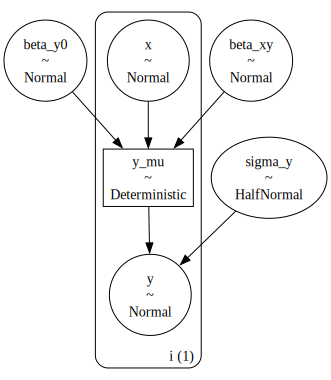

In [50]:
pm.model_to_graphviz(model_generative)

## Simulazione dei dati

Dopo aver definito l'intera distribuzione congiunta, useremo quest'ultima per generare dati simulati a partire dal modello, utilizzando parametri noti. Successivamente, testeremo se siamo in grado di recuperare questi parametri. Per farlo, indicheremo alcuni valori "veri" per i parametri che governano le relazioni causali tra i nodi.

Ovviamente, in scenari reali, non conosceremo i valori effettivi di questi parametri. Qui li conosciamo solo perché stiamo generando dati simulati e quindi siamo a conoscenza della verità di base. Il nostro obiettivo è di testare quanto bene possiamo inferire i parametri noti utilizzando solamente i dati, in un esercizio chiamato "Recupero dei Parametri". Se non riusciamo a recuperare i parametri in un semplice scenario simulato, allora non dovremmo avere molta fiducia nella nostra capacità di stimare gli effetti reali in set di dati del mondo reale più complessi.

Sebbene ci siano altri metodi per raggiungere questo obiettivo, in questo caso useremo il nuovo operatore `do` per generare un nuovo modello con i parametri impostati su certi valori predefiniti.

In [51]:
true_values = {
    "beta_y0": 0.25,
    "beta_xy": 1.0,
    "sigma_y": 0.75
}

model_simulate = do(model_generative, true_values)

La funzione `do` in PyMC serve per creare una versione "fissata" di un modello generativo esistente. Questo processo di "fissare" il modello è essenziale quando si desidera generare dati simulati che seguono una determinata struttura, ovvero quando si conoscono i "veri" parametri che si desidera simulare. Ecco come funziona.

1. **Input**: La funzione `do` accetta due elementi principali: 
    - Un modello generativo esistente, definito come un oggetto `pymc.Model`.
    - Un dizionario (`true_values`) che specifica i valori a cui fissare le variabili casuali del modello.
    
2. **Output**: Restituisce un nuovo modello, in cui le variabili casuali originali sono sostituite da nodi costanti con i valori forniti nel dizionario.

- **Nel modello originale**: Le variabili come `sigma_y`, `beta_y0`, e `beta_xy` sono variabili aleatorie. Queste rappresentano l'incertezza sui parametri del modello e sono descritte da distribuzioni a priori.
  
- **Nel nuovo modello**: Queste variabili aleatorie diventano nodi costanti. Per esempio, `beta_y0` diventa una costante con valore 0.25, `beta_xy` diventa 1.0, e `sigma_y` diventa 0.75.

Una volta ottenuto questo nuovo modello, possiamo usarlo per generare dati simulati. In questo contesto, usiamo la funzione `pm.sample_prior_predictive` per ottenere 100 campioni dalla distribuzione $ P(X, Y \mid \theta) $. Si noti che utilizziamo `pm.sample_prior_predictive` invece di `pm.sample` perché il nostro obiettivo è generare dati piuttosto che fare inferenza.

In sintesi, la funzione `do` ci permette di passare da un modello di incertezza a un modello più "deterministico", utile per la simulazione di dati sotto condizioni controllate.

In [58]:
N = 100 

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=rng)

Sampling: [x, y]


Creiamo il DataFrame `df` usando i dati simulati.

In [59]:
observed = {
    "y": simulate.prior["y"].values.flatten(),
    "x": simulate.prior["x"].values.flatten(),
}

df = pd.DataFrame(observed).sort_values("x", ascending=False)
df.shape

(100, 2)

In [60]:
df.head()

,y,x
35,2.396621,2.754635
93,2.239598,2.589630
29,3.695974,2.314935
65,3.256058,2.222837
47,1.442206,1.897905


Creiamo un diagramma a dispersione.

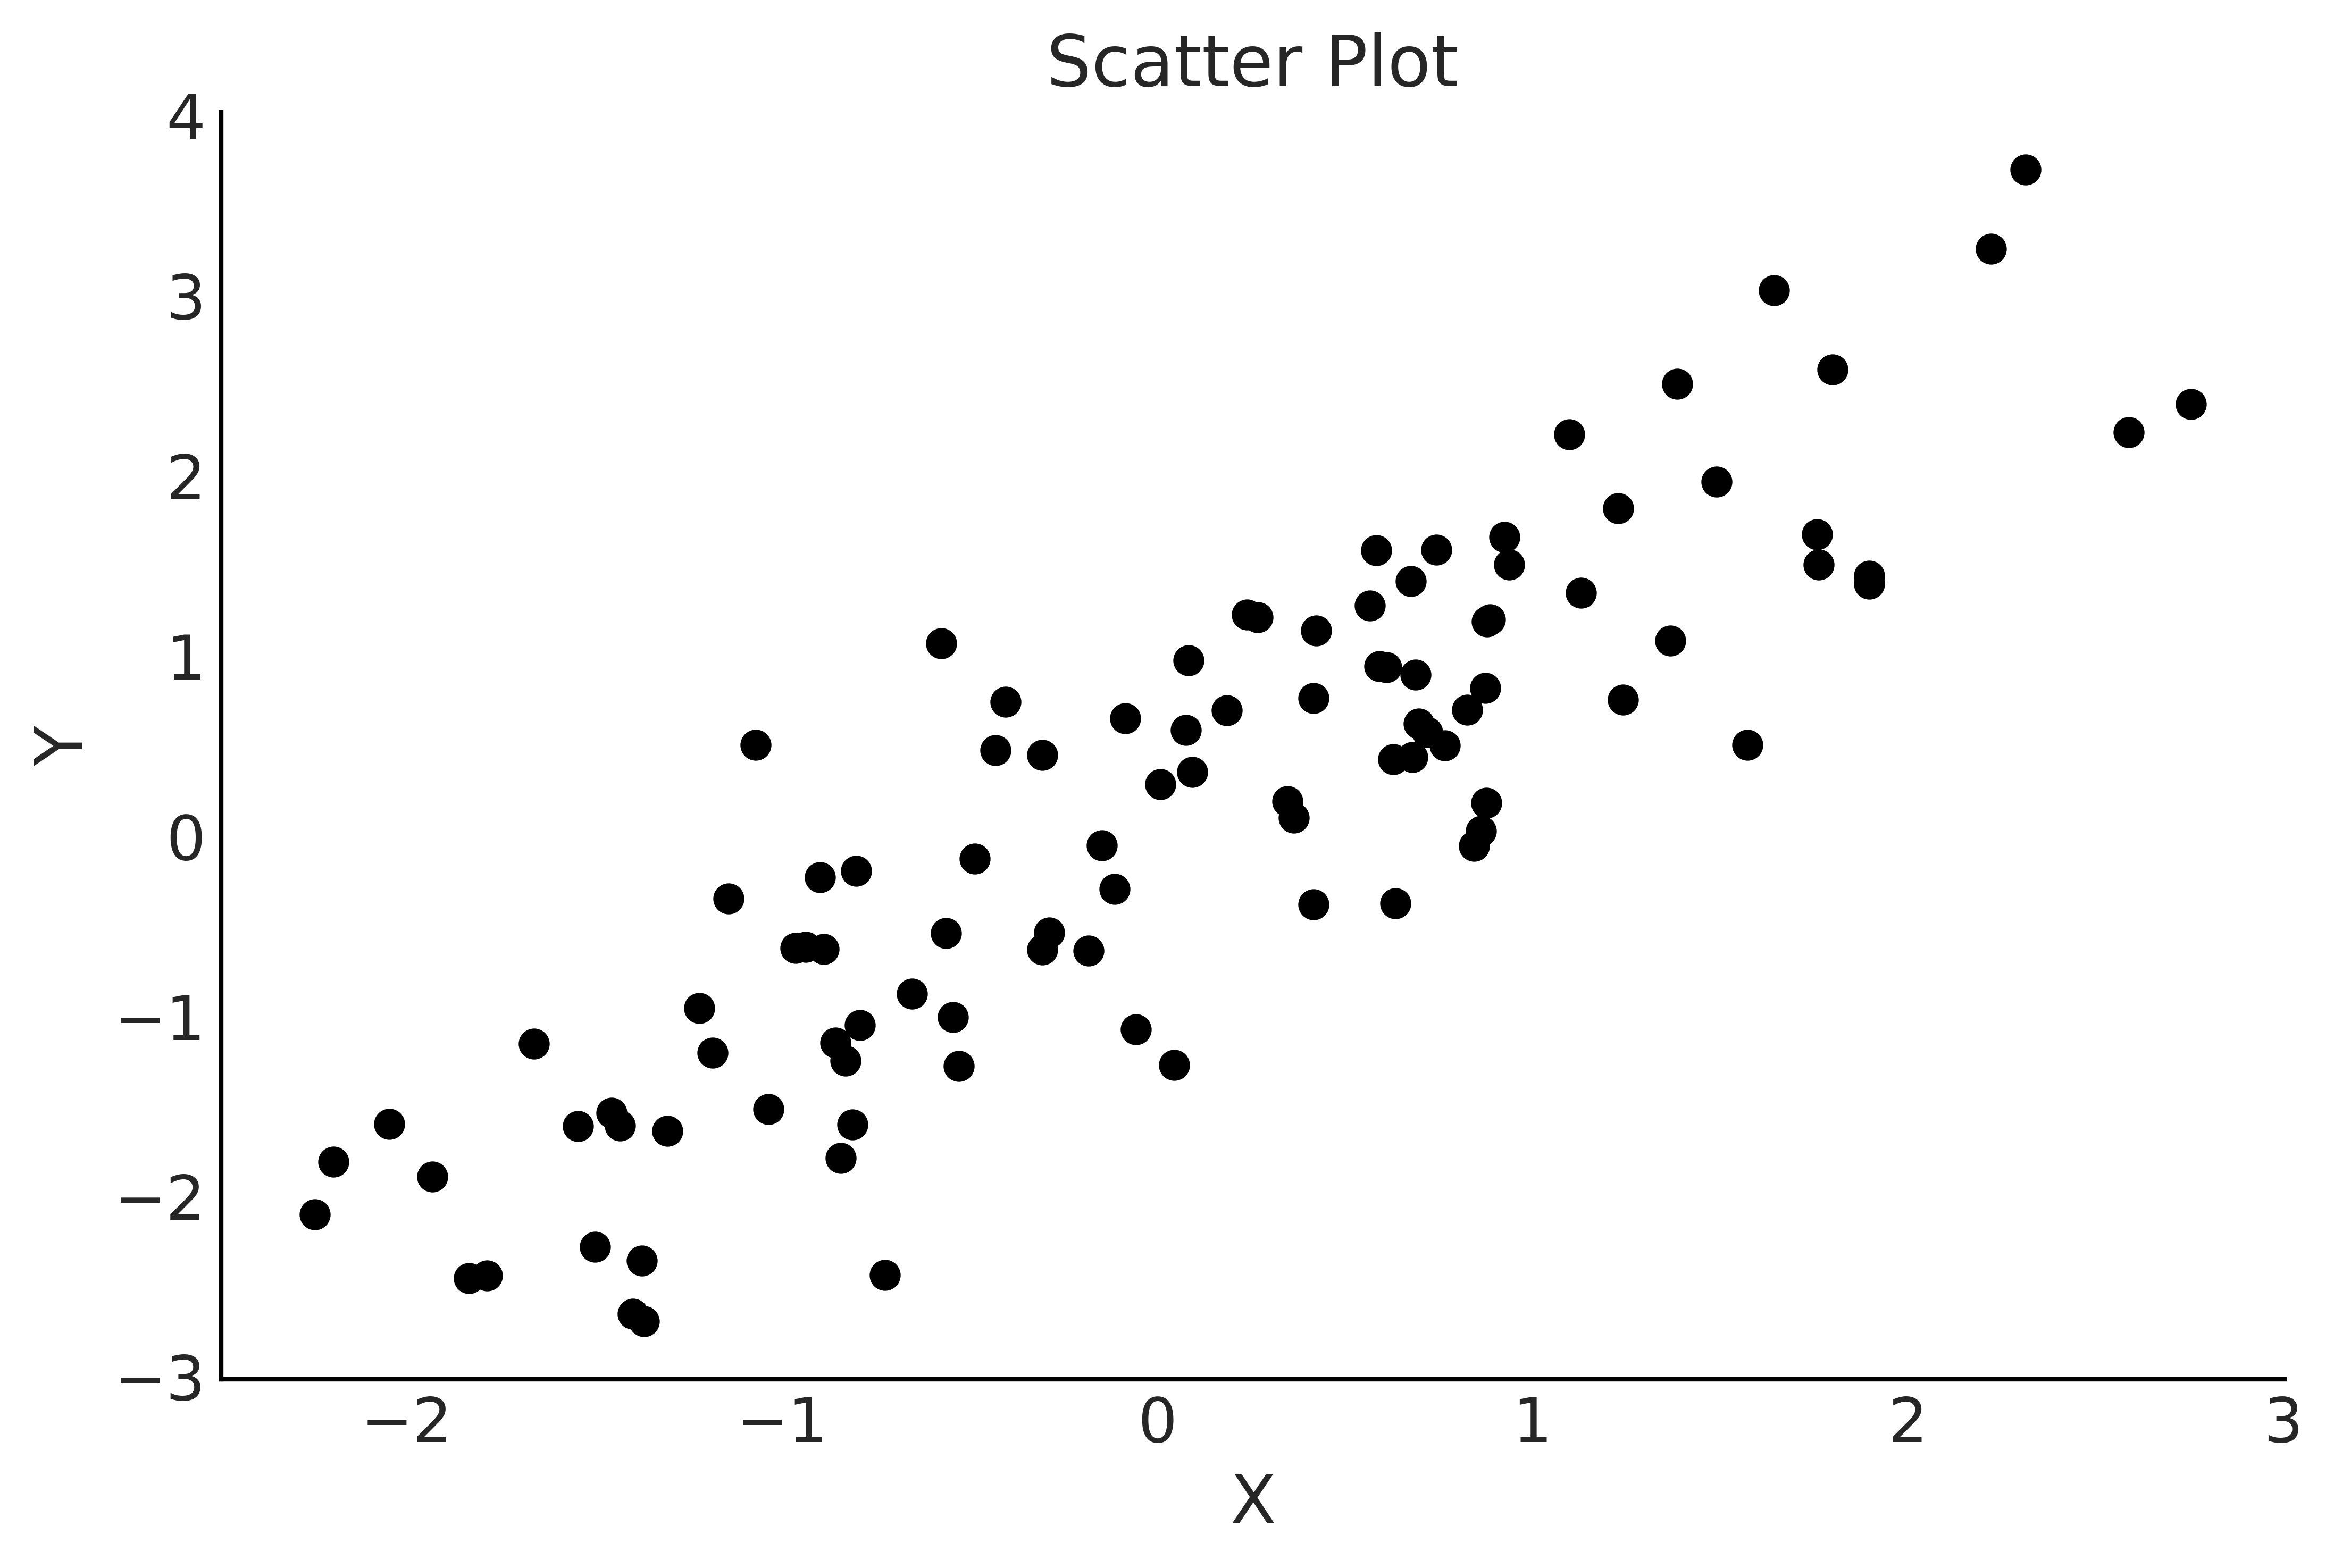

In [61]:
plt.scatter(df["x"], df["y"])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot")
plt.show()

## Inferenza

Passiamo ora all'inferenza. Per farlo, potremmo semplicemente ridefinire il modello sopra indicato e utilizzare l'argomento `observed`, come è comune fare in PyMC.

In [62]:
# Numero di osservazioni nei dati
N = len(df)

# Valori osservati
obs_x = df["x"].values
obs_y = df["y"].values

with pm.Model(coords={"i": np.arange(N)}) as model_inference:
    # Priori debolmente informativi su Y <- X
    beta_y0 = pm.Normal("beta_y0", mu=0, sigma=1)
    beta_xy = pm.Normal("beta_xy", mu=0, sigma=1)

    # Rumore delle osservazioni Y
    sigma_y = pm.HalfNormal("sigma_y", sigma=1)

    # Nodo principale e relazione causale (qui usiamo i dati osservati)
    x = pm.Data("x", obs_x, dims="i")

    # Nodo deterministico per la media di Y
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_xy * x), dims="i")

    # Verosimiglianza di Y (qui usiamo i dati osservati)
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, observed=obs_y, dims="i")

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


Eseguiamo il campionamento.

In [64]:
with model_inference:
    idata1 = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:01.146384
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 615.29it/s]

Sampling time =  0:00:03.425023
Transforming variables...
Transformation time =  0:00:00.022914


Esaminiamo le distribuzioni a posteriori dei parametri.

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_52313/122995699.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


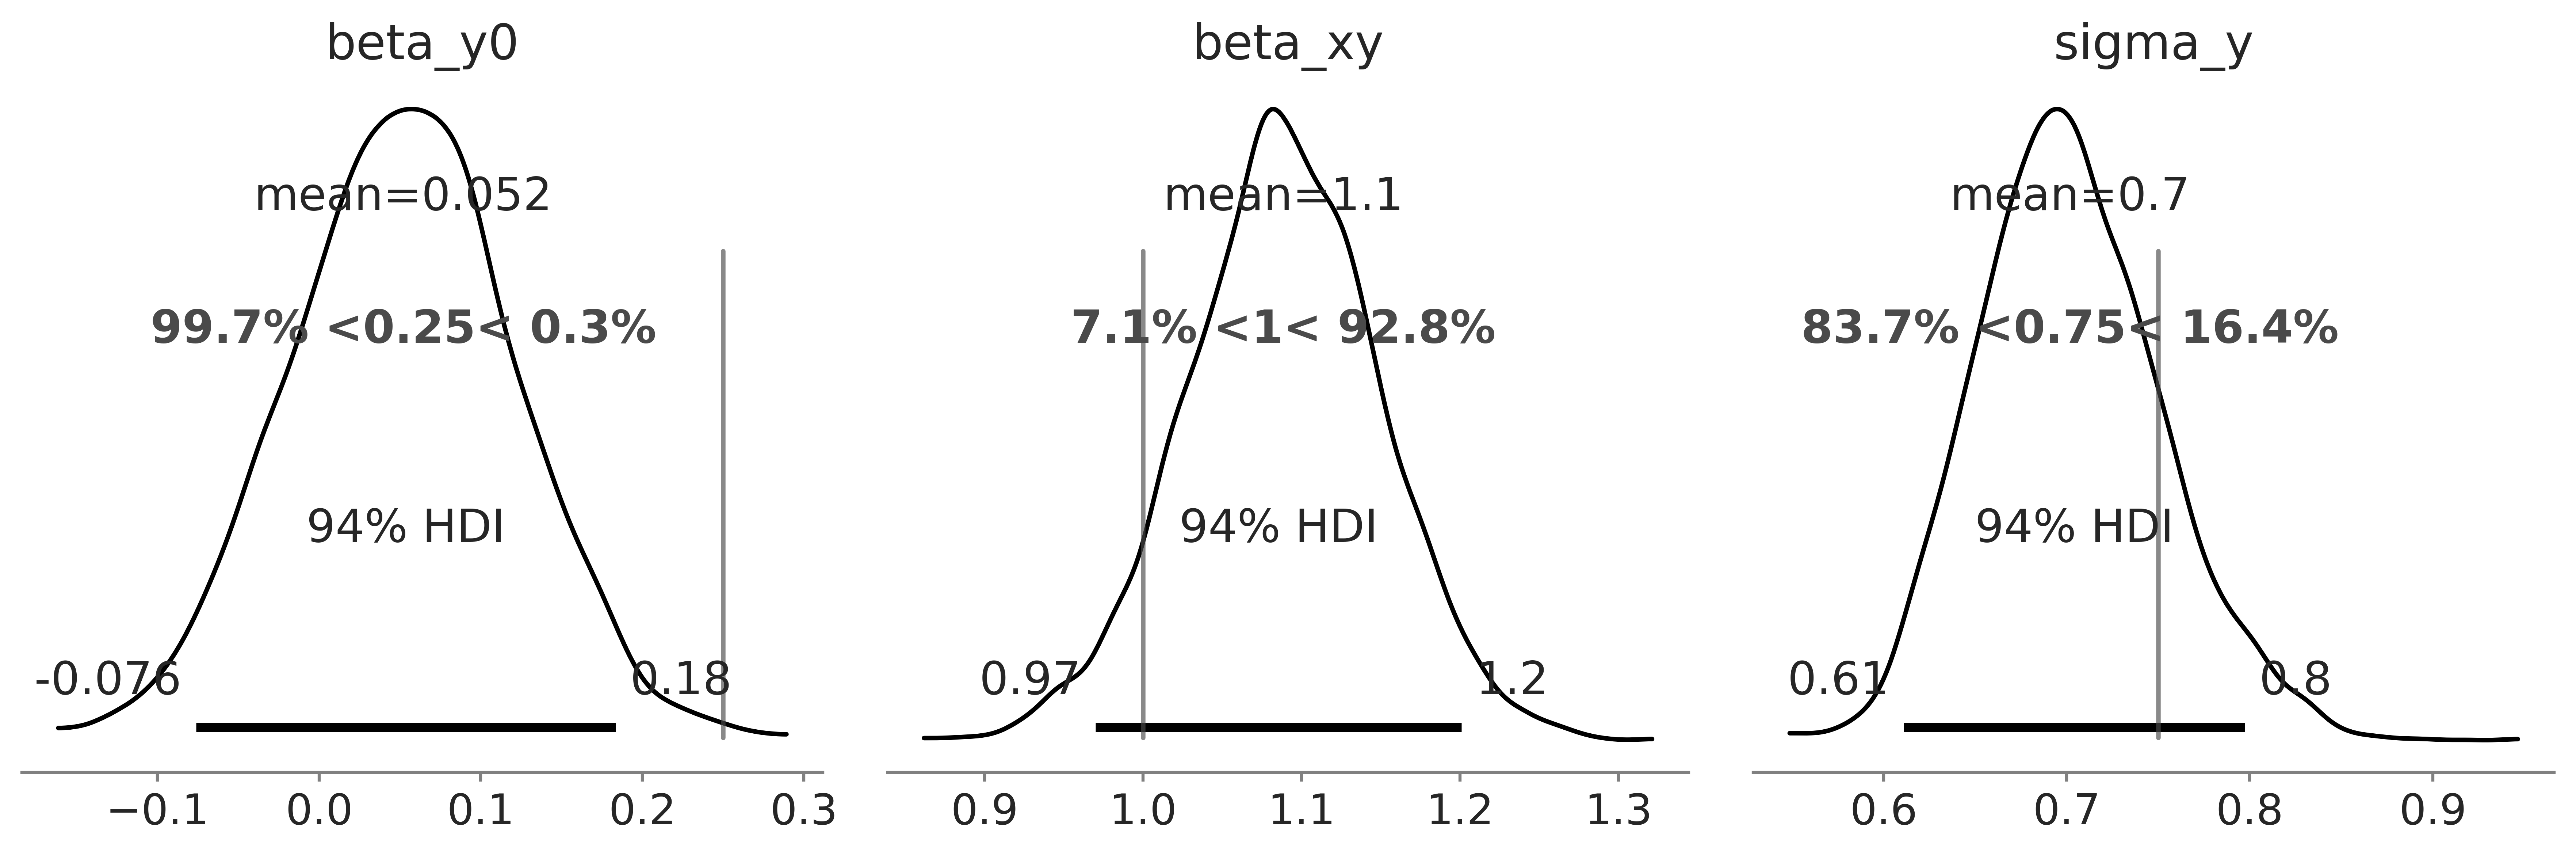

In [65]:
az.plot_posterior(
    idata1,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 4),
)
plt.tight_layout();

Tuttavia, possiamo fare qualcosa di un po' più interessante utilizzando un'altra nuova funzione chiamata `observe()`. Questa funzione prende un modello e dei dati, e restituisce un nuovo modello in cui i dati sono impostati come osservati sulla nostra variabile casuale di interesse, in modo simile alla funzione `do()`.

È importante notare che vogliamo derivare questo modello osservato dal nostro modello "vuoto" originale `model_generative` menzionato sopra, in cui nessun parametro era fissato.

In [68]:
model_inference2 = observe(model_generative, {"x": df["x"], "y": df["y"]})
model_inference2.set_dim("i", N, coord_values=np.arange(N))

Eseguiamo il campionamento.

In [70]:
with model_inference2:
    idata2 = pm.sampling_jax.sample_numpyro_nuts(random_seed=rng)

Compiling...
Compilation time =  0:00:01.338879
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 608.33it/s]

Sampling time =  0:00:03.475149
Transforming variables...
Transformation time =  0:00:00.025658


Esaminiamo le distribuzioni a posteriori dei parametri.

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_52313/1972052089.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


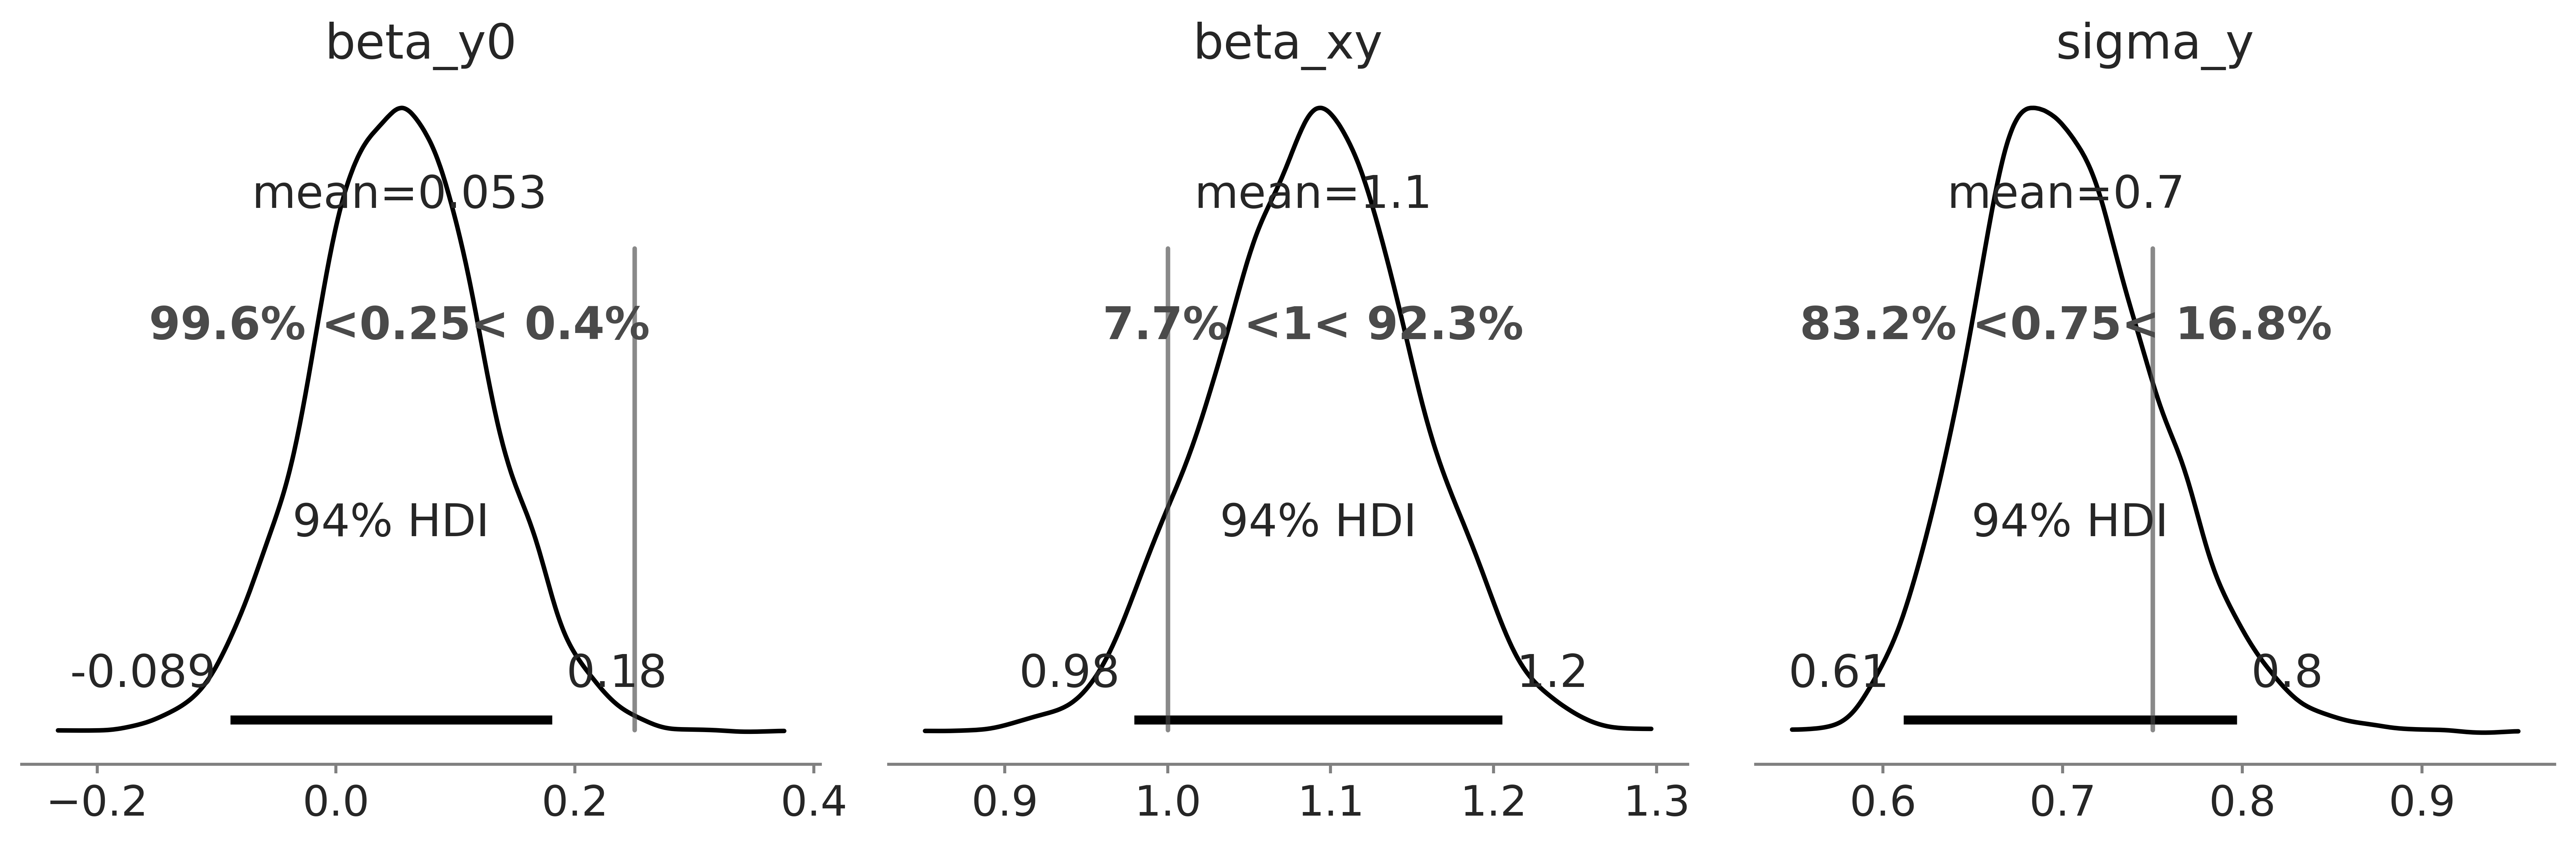

In [71]:
az.plot_posterior(
    idata2,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 4),
)
plt.tight_layout();

## Commenti e considerazioni conclusive

In questo capitolo, abbiamo esaminato come utilizzare PyMC per definire un modello generativo dei dati, specificamente per un modello di regressione lineare bivariato. Nel contesto bayesiano, questo modello generativo è rappresentato come una rete bayesiana, in cui ogni variabile casuale diventa un nodo all'interno della rete.

Una rete bayesiana è una struttura grafica che rappresenta le relazioni causali e di dipendenza probabilistica tra variabili casuali. Ogni nodo nella rete rappresenta una variabile casuale, mentre gli archi tra i nodi indicano relazioni dirette o causali. La rete fornisce un quadro per incorporare sia le informazioni strutturali che le incertezze, permettendo una rappresentazione visuale e concettuale del modello generativo dei dati.

Le reti bayesiane non solo mappano le relazioni causali, ma forniscono anche una struttura per quantificare l'incertezza associata a ciascuna variabile. Questa incertezza è modellata attraverso distribuzioni di probabilità. In un modello di regressione lineare, per esempio, i coefficienti della regressione e il termine di errore sono rappresentati come variabili casuali con distribuzioni a priori.

Abbiamo inoltre discusso come effettuare inferenza bayesiana sui dati generati dal modello. In particolare, abbiamo introdotto la funzione `observe`, che prende come argomenti il modello generativo e i dati osservati. Questa funzione modifica il modello originale, impostando le variabili osservate come 'conosciute' e lasciando le altre come 'sconosciute', preparando il terreno per l'inferenza bayesiana. Questo processo ci permette di aggiornare le nostre credenze sulle variabili sconosciute (parametri, in questo caso) alla luce dei dati osservati.

In sintesi, le reti bayesiane offrono un quadro robusto e flessibile per modellare le relazioni causali e le incertezze in un'ampia varietà di contesti, e PyMC fornisce gli strumenti per eseguire inferenze bayesiane su tali modelli.

## Watermark

In [5]:
%load_ext watermark
%watermark -n -u -v -iv 

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu Sep 07 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

arviz            : 0.16.1
scipy            : 1.11.2
seaborn          : 0.12.2
numpy            : 1.25.2
matplotlib       : 3.7.2
pymc_experimental: 0.0.11
networkx         : 3.1
pymc             : 5.8.0
pandas           : 2.1.0

